In [124]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AffinityPropagation
import seaborn as sns
from sklearn.metrics import silhouette_score



In [125]:
# read the data
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [126]:
df.shape

(200, 5)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [128]:
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## Preprocess the data

- Convert the categorical Genre column to numerical values.
- Drop the CustomerID column as it is not relevant for clustering.


In [129]:
# # convert "Genre" column to numeric column
# df["Genre"] = pd.Categorical(df["Genre"])
# df["Genre"] = df["Genre"].cat.codes
# df.dtypes

# Convert 'Genre' column to numerical values
le = LabelEncoder()
df['Genre'] = le.fit_transform(df['Genre'])

# Drop the CustomerID column
df = df.drop('CustomerID', axis=1)

## Apply Affinity Propagation

In [130]:
# Initialize Affinity Propagation model
affinity_propagation = AffinityPropagation(random_state=42)
affinity_propagation.fit(df)

# Get the cluster labels
labels = affinity_propagation.labels_
exemplars = affinity_propagation.cluster_centers_indices_
df['Cluster'] = labels
df

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,2
1,1,21,15,81,1
2,0,20,16,6,2
3,0,23,16,77,1
4,0,31,17,40,2
...,...,...,...,...,...
195,0,35,120,79,11
196,0,45,126,28,10
197,1,32,126,74,11
198,1,32,137,18,10


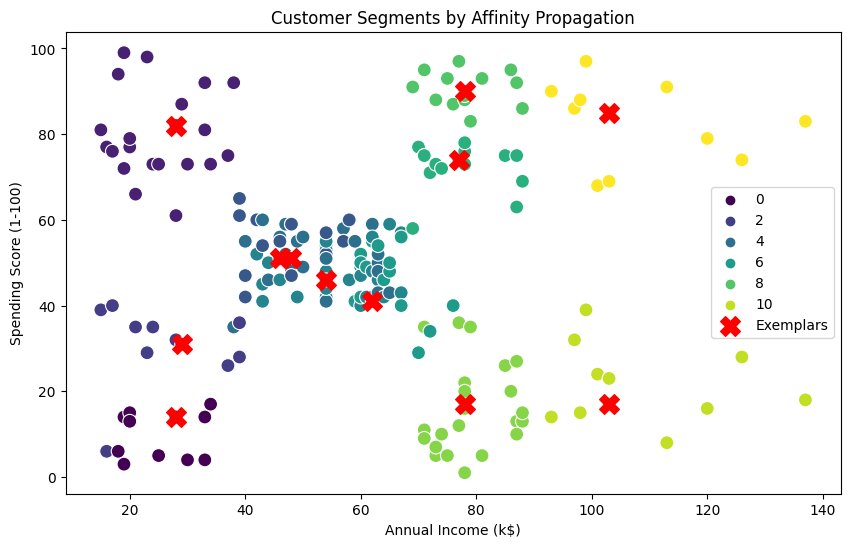

In [131]:
# 1. Visualizing the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', data=df, s=100)
plt.scatter(df.iloc[exemplars]['Annual Income (k$)'], df.iloc[exemplars]['Spending Score (1-100)'], color='red', s=200, marker='X', label='Exemplars')
plt.title('Customer Segments by Affinity Propagation')
plt.legend()
plt.show()

In [132]:
# 2. Analyzing Cluster Centers (Exemplars)
print("Cluster Exemplars (Center Points):")
print(df.iloc[exemplars])

Cluster Exemplars (Center Points):
     Genre  Age  Annual Income (k$)  Spending Score (1-100)  Cluster
24       0   54                  28                      14        0
25       1   29                  28                      82        1
28       0   40                  29                      31        2
58       0   27                  46                      51        3
64       1   63                  48                      51        4
85       1   48                  54                      46        5
100      0   23                  62                      41        6
147      0   32                  77                      74        7
149      1   34                  78                      90        8
150      1   43                  78                      17        9
188      0   41                 103                      17       10
189      0   36                 103                      85       11


In [133]:
# 3. Calculating the Silhouette Score
silhouette_avg = silhouette_score(df.drop('Cluster', axis=1), labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.35


- as we can see above the model performance is very bad so we will try to improve it 

## Scaling the Data

In [134]:
# Scale the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.drop(columns='Cluster', errors='ignore'))

## Tuning Parameters

In [135]:
# Tune AffinityPropagation parameters
preference_values = np.linspace(-20, -5, 10)  # Range of preference values
best_score = -1
best_params = None
best_labels = None

for preference in preference_values:
    model = AffinityPropagation(preference=preference, random_state=42)
    model.fit(scaled_df)
    labels = model.labels_

    # Check if valid number of clusters were formed
    if len(set(labels)) > 1:
        score = silhouette_score(scaled_df, labels)
        
        if score > best_score:
            best_score = score
            best_params = {'preference': preference}
            best_labels = labels

# Output the best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.2f}")

# Assign the best labels to the original dataframe
df['Cluster'] = best_labels
df.head()

Best Parameters: {'preference': -16.666666666666668}
Best Silhouette Score: 0.42


,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,2
1,1,21,15,81,2
2,0,20,16,6,3
3,0,23,16,77,0
4,0,31,17,40,3


## Model Evaluation

Silhouette Score after Tuning: 0.42


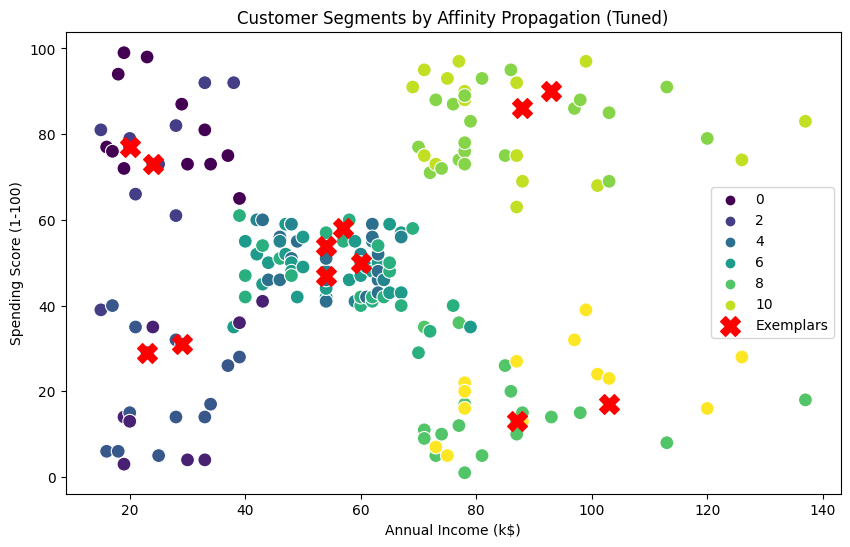

In [136]:
# Initialize Affinity Propagation with the best parameters
best_affinity_propagation = AffinityPropagation(random_state=42, **best_params)

# Fit the model
best_affinity_propagation.fit(scaled_df)

# Get the cluster labels and exemplars
labels = best_affinity_propagation.labels_
exemplars = best_affinity_propagation.cluster_centers_indices_

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(scaled_df, labels)
print(f"Silhouette Score after Tuning: {silhouette_avg:.2f}")
df['Cluster'] = labels

# Visualize the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', data=df, s=100)
plt.scatter(df.iloc[exemplars]['Annual Income (k$)'], df.iloc[exemplars]['Spending Score (1-100)'], color='red', s=200, marker='X', label='Exemplars')
plt.title('Customer Segments by Affinity Propagation (Tuned)')
plt.legend()
plt.show()

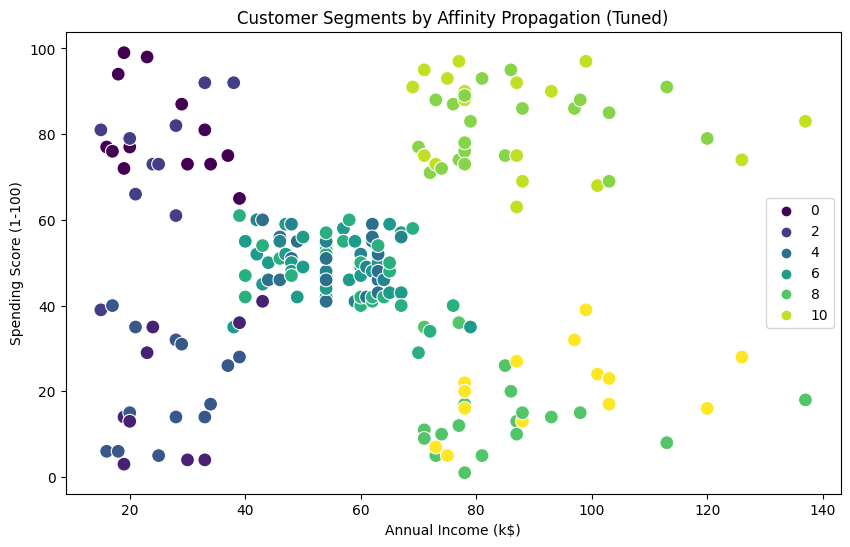

In [137]:
# Add the best cluster labels to the original DataFrame
df['Cluster'] = best_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', data=df, s=100)
plt.title('Customer Segments by Affinity Propagation (Tuned)')
plt.legend()
plt.show()
